In [ ]:
#@title Print TF version and GPU stats
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.7.0
Found GPU at: /device:GPU:0

Tue Jan 25 17:24:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    264MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

In [ ]:
#@title Dataset Downloader
import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
def unzip(file, destination=None):
  if not destination or not os.path.isdir(destination):
    destination = os.path.dirname(file)
  print('unzipping to ',destination)
  zip_ref = zipfile.ZipFile(file, 'r')
  zip_ref.extractall(destination)
  zip_ref.close()
    
download_file_from_google_drive('1UC77Z-Zon-NV9G_CxKbI1weFyd9relb7', '/plantclef_data.zip') # flowers10
unzip('/plantclef_data.zip', '/tmp')

train_dir = '/tmp/plantclef_data/train'
val_dir = '/tmp/plantclef_data/test'

unzipping to  /tmp


In [ ]:
#@title Prepare Data Generators
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 512

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.4,
                                   brightness_range=(.5, 1.5),
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(64,64),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True,
                    seed=42)

num_classes = train_generator.num_classes

# Flow test images in batches using val_datagen generator
val_generator = val_datagen.flow_from_directory(
                    val_dir,
                    target_size=(64,64),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=False)

train_steps = len(train_generator)
val_steps = len(val_generator)

Found 20359 images belonging to 241 classes.
Found 5092 images belonging to 241 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
"""ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](
    https://arxiv.org/abs/1512.03385) (CVPR 2016 Best Paper Award)
Adapted from code contributed by BigMoyan.
"""
import os
import warnings
from tensorflow.keras import layers, models, backend, utils

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'


    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x


def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def ResNet50(input_shape=None,
             classes=10):
    """Instantiates the ResNet50 architecture.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    """
    
    img_input = layers.Input(shape=input_shape)

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
                      
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(classes, activation='softmax', name='fc10')(x)
    
    model = Model(img_input, x)

    model.compile(loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=1e-3),
            metrics=['accuracy'])

    return model

In [ ]:
resnet50_nf = ResNet50(input_shape=(64,64,3), classes=num_classes)

In [ ]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show() 

The bad accuracy in the validation data can be explain by the fact that each class does not have the same amount of images as the other. This number is quite different for each class. So, one improvement that can be done with this dataset is to make even the images in each class.

Epoch 1/100
40/40 [==============================] - 68s 1s/step - loss: 31.6871 - accuracy: 0.0165 - val_loss: 5.2304 - val_accuracy: 0.0206
Epoch 2/100
40/40 [==============================] - 40s 998ms/step - loss: 4.9295 - accuracy: 0.0297 - val_loss: 5.1621 - val_accuracy: 0.0224
Epoch 3/100
40/40 [==============================] - 39s 964ms/step - loss: 4.7059 - accuracy: 0.0501 - val_loss: 5.0573 - val_accuracy: 0.0275
Epoch 4/100
40/40 [==============================] - 39s 967ms/step - loss: 4.5044 - accuracy: 0.0680 - val_loss: 5.0399 - val_accuracy: 0.0344
Epoch 5/100
40/40 [==============================] - 39s 975ms/step - loss: 4.3914 - accuracy: 0.0746 - val_loss: 5.0523 - val_accuracy: 0.0275
Epoch 6/100
40/40 [==============================] - 39s 973ms/step - loss: 4.3187 - accuracy: 0.0880 - val_loss: 4.9246 - val_accuracy: 0.0363
Epoch 7/100
40/40 [==============================] - 39s 970ms/step - loss: 4.2294 - accuracy: 0.0945 - val_loss: 4.9181 - val_accuracy: 0

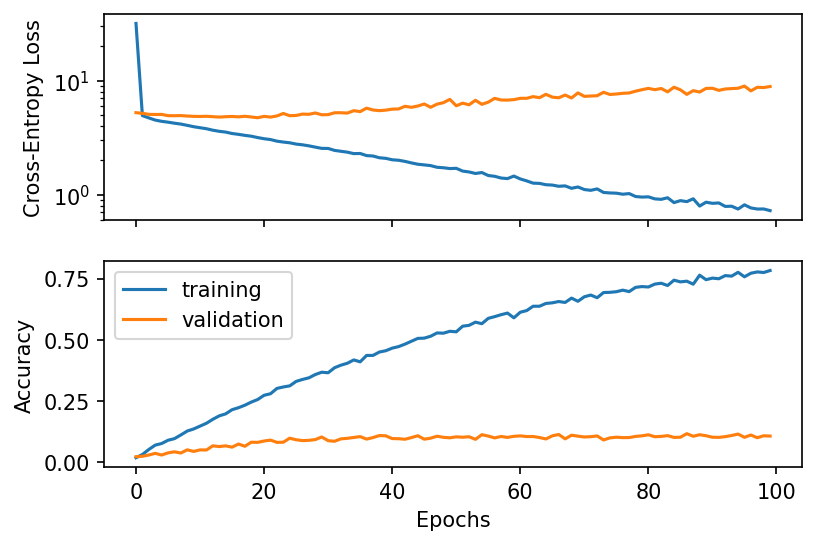

In [ ]:
history = resnet50_nf.fit(train_generator,
                      steps_per_epoch=train_steps,# trained with 512
                      epochs=100,
                      validation_data=val_generator,
                      validation_steps=val_steps
                       )
plot_history(history)